Settings of the notebook: 
- Prior on alpha pareto is like mobster 1D
- Delta initialized based on the likelihood value of the centroids of kmeans
- Initial variance of beta is high (50) 

In [1]:
from mobster_mv2 import mobster_MV

import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy.stats import pareto, beta, uniform, norm, lognorm
import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sys

# Set the parent directory
parent_dir = "../.."
# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)
from plot_functions import *
from create_beta_pareto_dataset import *
from BoundedPareto import BoundedPareto


%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [3]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, probs_beta, a_beta, b_beta, weights):
    return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)


def pareto_lk(data, DP, probs_pareto, alpha, weights):
    return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)


def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta"][k, dim]
        k_beta = mb.params["k_beta"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        probs_beta = mb.params["probs_beta"][k, dim]
        return log_sum_exp(beta_lk(NV, DP, probs_beta, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto"][k, dim]
        probs_pareto = mb.params["probs_pareto"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, probs_pareto, alpha, weights)).sum()

### 1D -> 2D model

In [40]:
import pickle
# Load pkl data
# These data contains a mixture with 1 Pareto and 2 beta components 
def load_example_data(directory = "./"):
    flh = open(directory + "example.pkl", "rb")
    inp = pickle.load(flh)
    inp = {k: v.float().round() for k, v in zip(inp.keys(), inp.values())}
    return inp

In [41]:
data = load_example_data("./")
len(data["1:1"])

961

In [42]:
data

{'1:1': tensor([[  7., 112.],
         [  6., 101.],
         [  7., 106.],
         ...,
         [ 47., 114.],
         [ 64., 121.],
         [ 66., 138.]])}

In [43]:
data = data["1:1"]

In [44]:
data

tensor([[  7., 112.],
        [  6., 101.],
        [  7., 106.],
        ...,
        [ 47., 114.],
        [ 64., 121.],
        [ 66., 138.]])

In [45]:
data.shape

torch.Size([961, 2])

In [46]:
N = len(data)
print(N)

961


In [47]:
NV0 = torch.ones(N)*0.
DP0 = torch.ones(N)*100

In [48]:
NV = torch.stack((data[:,0],NV0), dim=1)
DP = torch.stack((data[:,1],DP0), dim=1)
print(NV.shape)
print(DP.shape)

torch.Size([961, 2])
torch.Size([961, 2])


In [49]:
labels_1 = np.zeros(N)
labels_2 = np.ones(N)
labels = np.concatenate((labels_1, labels_2))

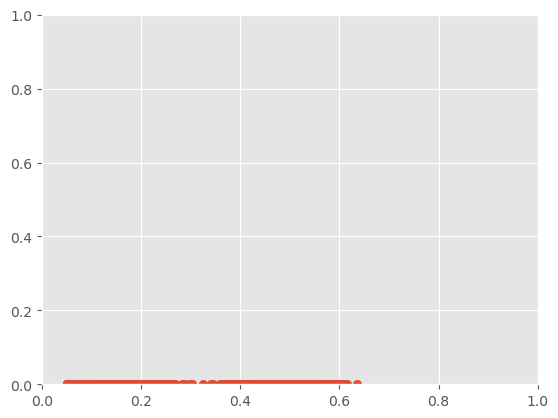

In [50]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])#, c = labels)

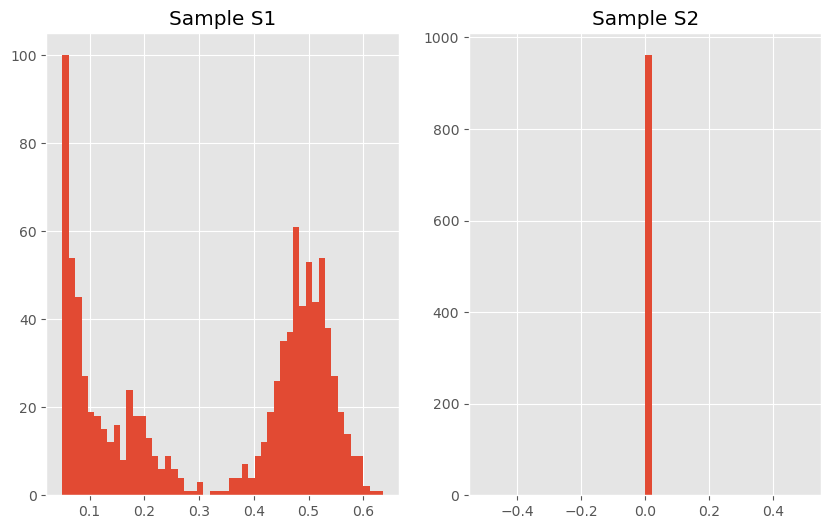

In [51]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[0.4943, 0.0010],
        [0.0785, 0.0010],
        [0.2019, 0.0010]])
Iteration 0: Loss = -8447008.0
weights_param tensor([0.4073, 0.5301, 0.0626], grad_fn=<DivBackward0>)
tail_mean_param tensor([[1.9801, 1.9801],
        [1.9801, 2.0201],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
alpha_prec_param tensor([[2.0201, 1.9801],
        [1.9801, 2.0201],
        [2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[2.1985, 0.6118],
        [1.5608, 4.8709],
        [2.7470, 2.6582]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.4945, 0.0010],
        [0.0792, 0.0010],
        [0.2031, 0.0010]], grad_fn=<AddBackward0>)
k_beta_param tensor([[50.5025, 50.5025],
        [50.5025, 50.5025],
        [50.5025, 50.5025]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.4942, 0.0010],
        [0.0792, 0.0010],
        [0.2031, 0.0010]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.4942, 0.0010],
        [0.0779, 0.0010],
        [0.2031, 

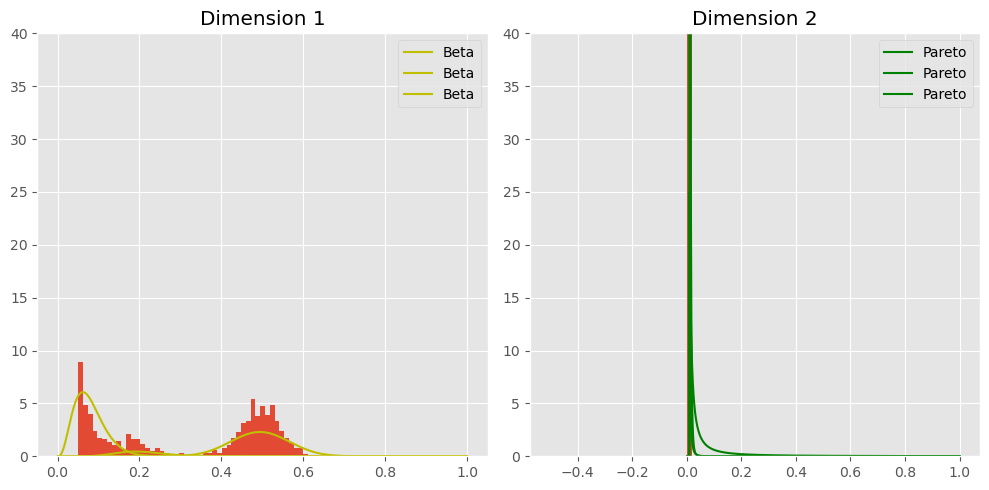

Iteration 200: Loss = -61849640.0
Iteration 400: Loss = -1403051904.0
probs_beta [[5.0394249e-01 7.1292860e-04]
 [3.2490793e-01 1.7175372e-04]
 [4.1043121e-01 2.3437032e-04]]


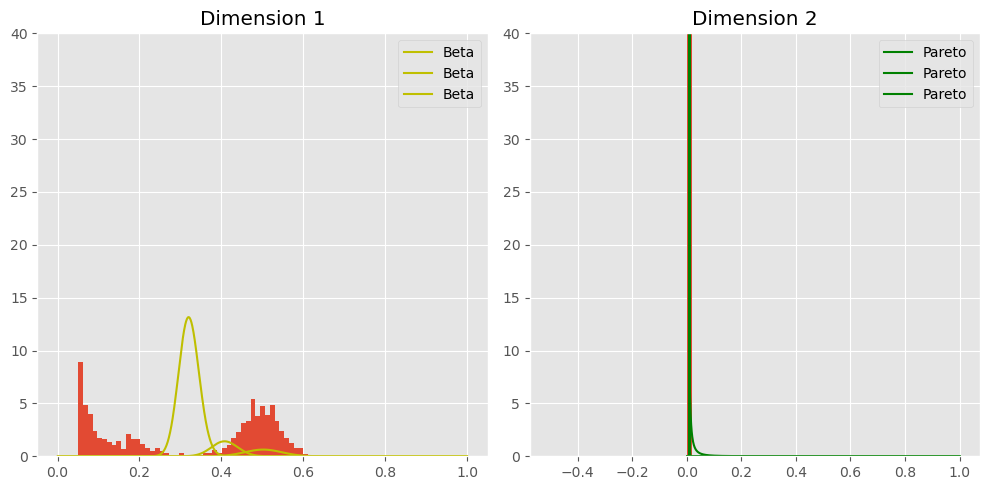

Iteration 600: Loss = -54804299776.0
Iteration 800: Loss = -3641926483968.0
probs_beta [[5.0394249e-01 7.1181462e-04]
 [4.2304829e-01 2.4328056e-05]
 [4.1043121e-01 4.1727133e-05]]


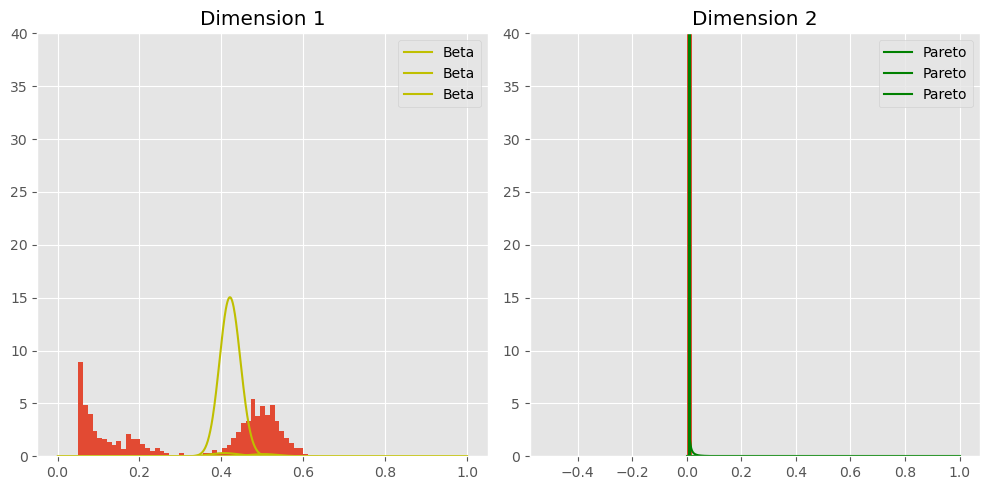

Iteration 1000: Loss = -363121130602496.0
Iteration 1200: Loss = -4.95401886065623e+16
probs_beta [[5.0394249e-01 7.1021152e-04]
 [4.4981530e-01 2.9048265e-06]
 [4.1043121e-01 5.5564292e-06]]


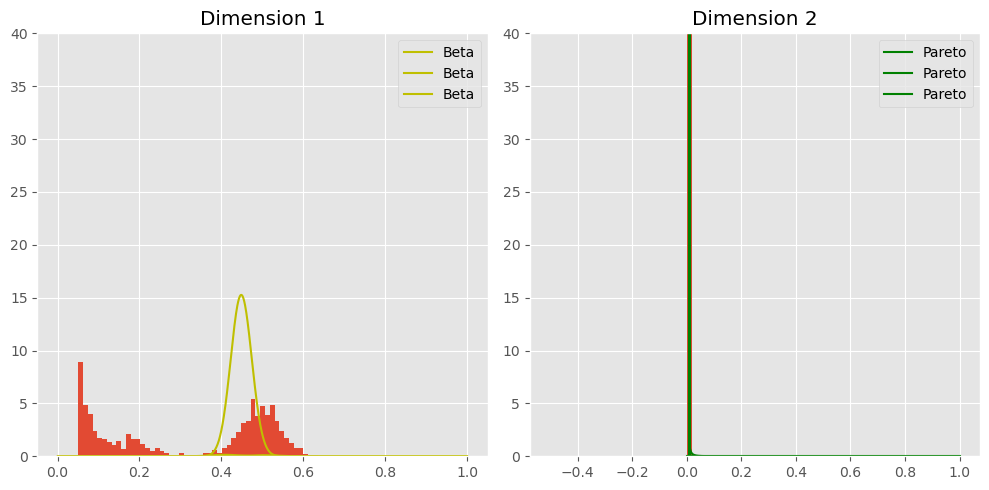

Iteration 1400: Loss = -8.655903640399118e+18
Iteration 1600: Loss = -1.4578693833128464e+20
probs_beta [[5.0394249e-01 7.0807902e-04]
 [4.6253848e-01 3.3870418e-07]
 [4.1043121e-01 6.7650899e-07]]


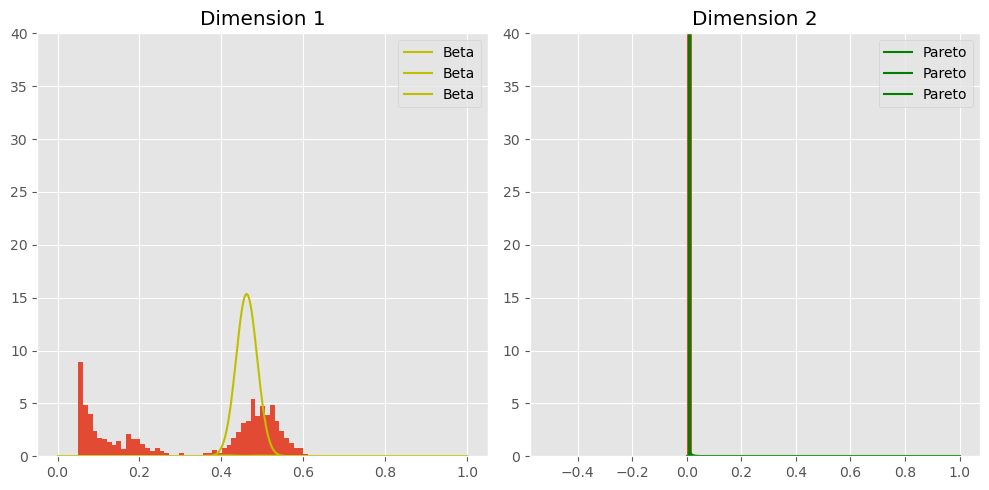

Iteration 1800: Loss = -1.55720313404706e+20
Iteration 2000: Loss = -1.632135467206506e+20
probs_beta [[5.0394249e-01 7.0535264e-04]
 [4.7014597e-01 4.0085222e-08]
 [4.1043121e-01 8.1322007e-08]]


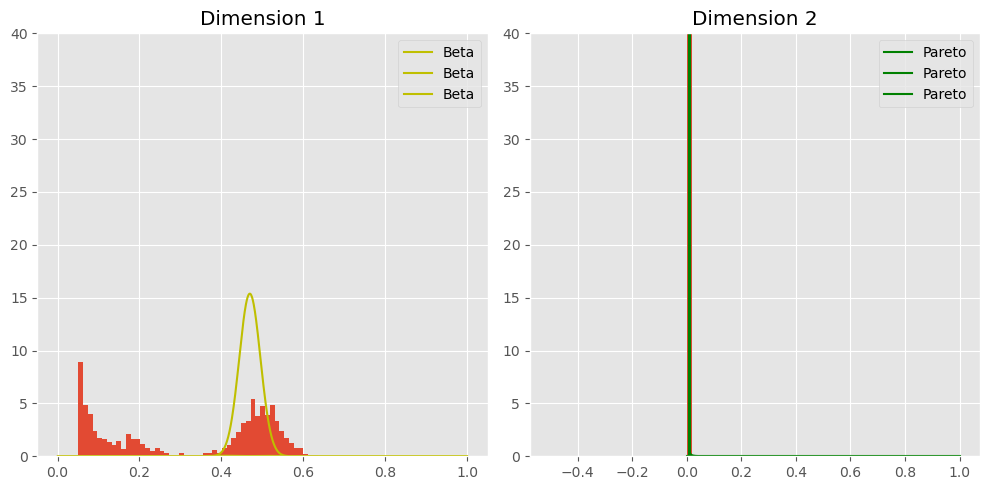

Iteration 2200: Loss = -1.697357617356876e+20
Iteration 2400: Loss = -1.757244937089277e+20
probs_beta [[5.0394249e-01 7.0193631e-04]
 [4.7522613e-01 4.8500142e-09]
 [4.1043121e-01 9.8823918e-09]]


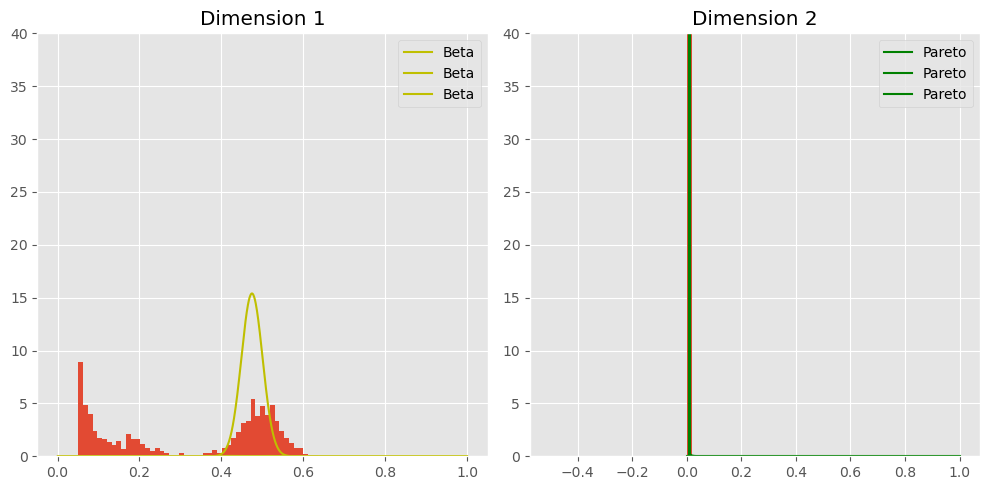

Iteration 2600: Loss = -1.8137693345374274e+20
Iteration 2800: Loss = -1.8680095625495708e+20
probs_beta [[5.0394249e-01 6.9770816e-04]
 [4.7880819e-01 5.9913524e-10]
 [4.1043121e-01 1.2206448e-09]]


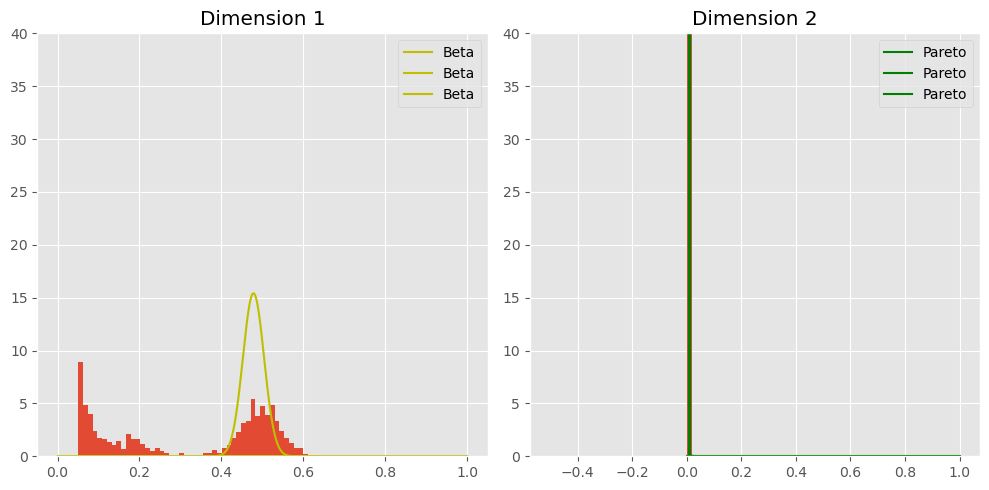

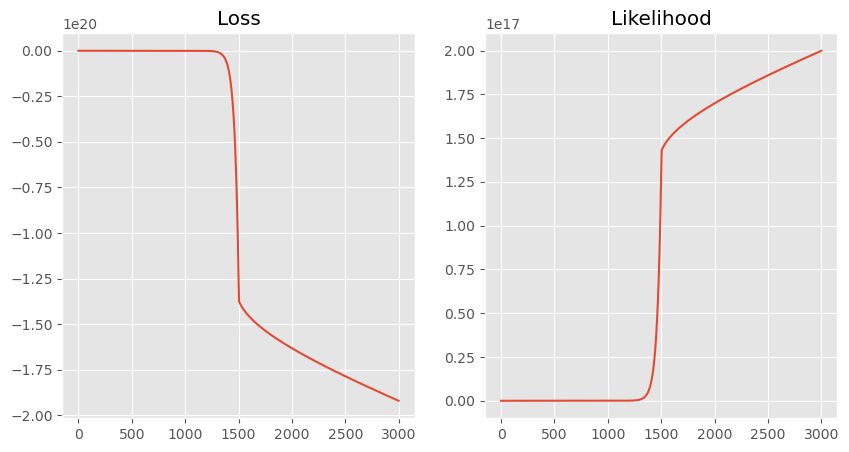

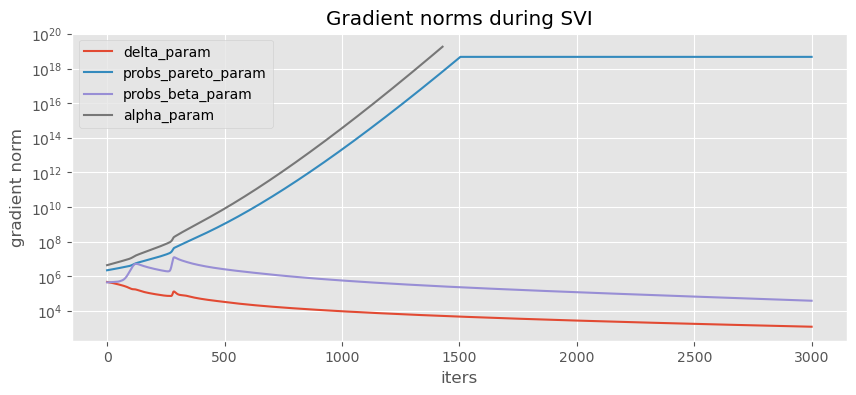

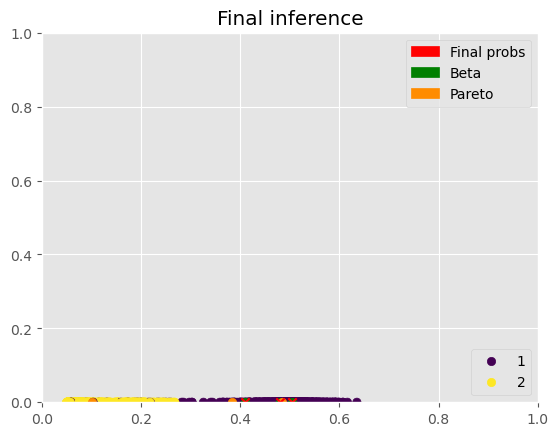

In [52]:
mb = mobster_MV(NV, DP, K = 3, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

In [53]:
mb.params

{'probs_beta': tensor([[5.0394e-01, 6.9526e-04],
         [4.8020e-01, 2.1312e-10],
         [4.1043e-01, 4.3385e-10]]),
 'probs_pareto': tensor([[4.8390e-01, 5.5388e-04],
         [1.0111e-01, 1.9144e-20],
         [3.8392e-01, 8.6363e-05]]),
 'weights': tensor([0.0016, 0.9964, 0.0020]),
 'delta': tensor([[[1.9970e-01, 8.0030e-01],
          [8.0121e-01, 1.9879e-01]],
 
         [[4.2734e-01, 5.7266e-01],
          [9.9904e-01, 9.5546e-04]],
 
         [[3.5517e-02, 9.6448e-01],
          [9.6430e-01, 3.5699e-02]]]),
 'alpha_pareto': tensor([[8.1923e-01, 1.1341e+00],
         [4.3223e-01, 5.0976e+12],
         [6.7193e-01, 3.5193e+01]]),
 'phi_beta': tensor([[5.0232e-01, 1.4188e-03],
         [4.8004e-01, 3.0457e-04],
         [4.0856e-01, 3.1876e-04]]),
 'k_beta': tensor([[199.9993, 200.0011],
         [376.0583, 200.0003],
         [200.0022, 200.0003]]),
 'responsib': tensor([[4.2886e-08, 1.9537e-07, 1.2051e-07,  ..., 6.4161e-04, 2.3348e-03,
          1.2762e-03],
         [2.7040e

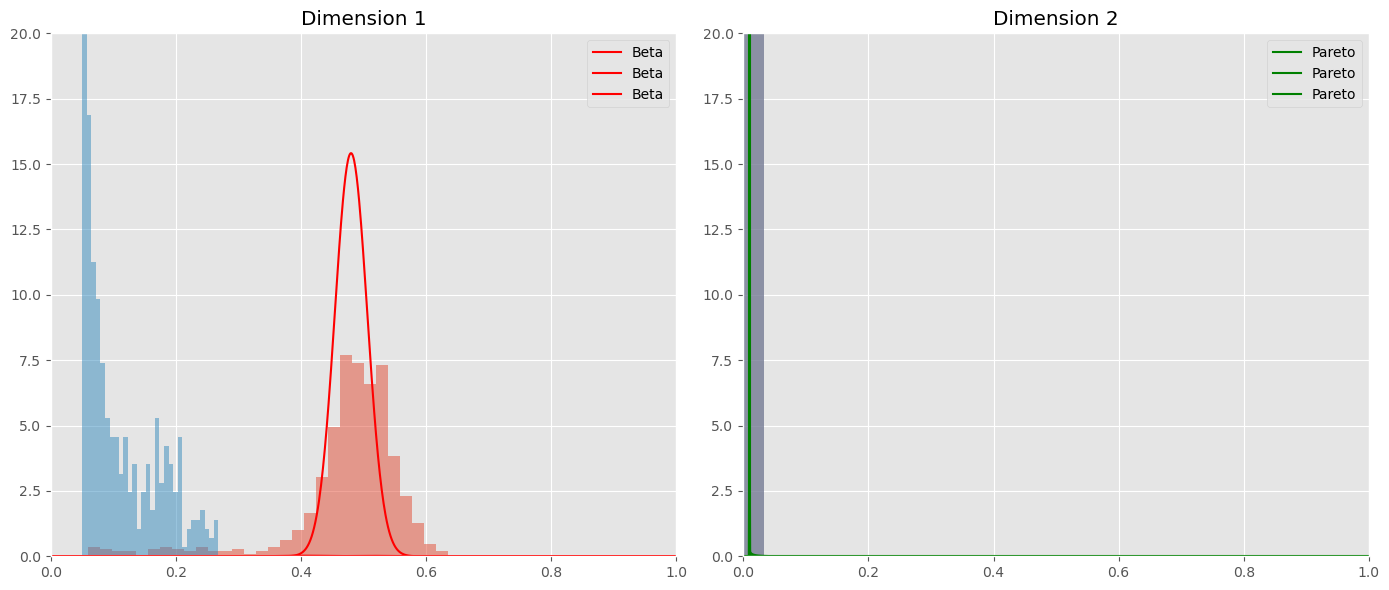

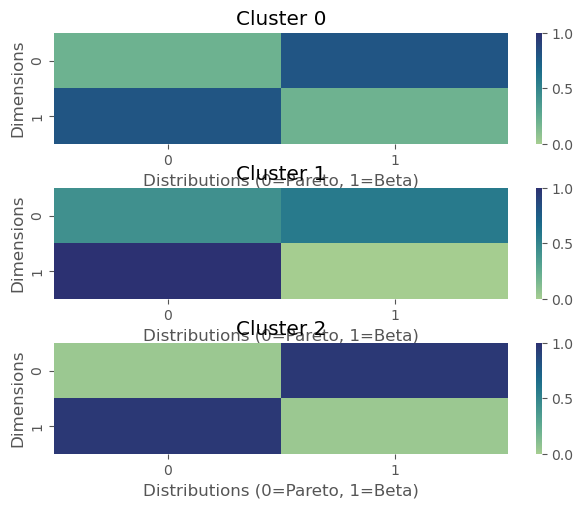

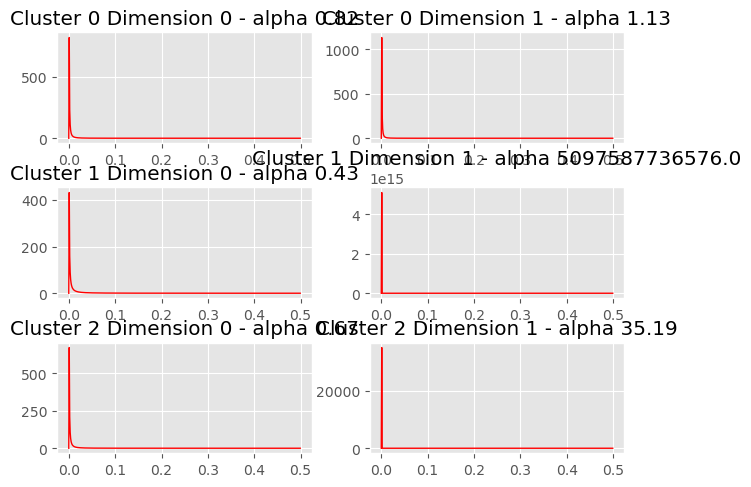

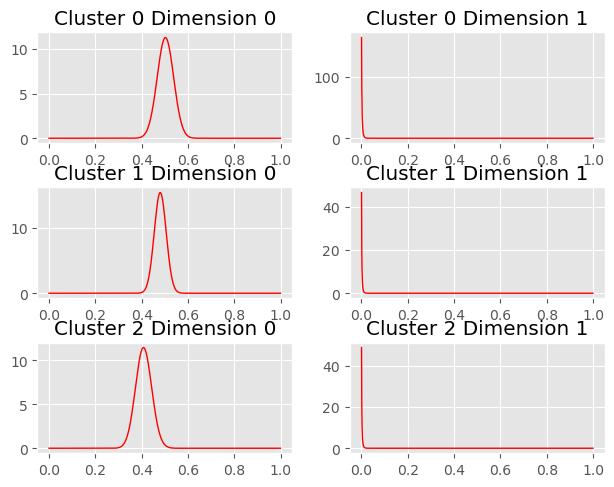

In [54]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [57]:
mb.params

{'probs_beta': tensor([[5.0394e-01, 6.9526e-04],
         [4.8020e-01, 2.1312e-10],
         [4.1043e-01, 4.3385e-10]]),
 'probs_pareto': tensor([[4.8390e-01, 5.5388e-04],
         [1.0111e-01, 1.9144e-20],
         [3.8392e-01, 8.6363e-05]]),
 'weights': tensor([0.0016, 0.9964, 0.0020]),
 'delta': tensor([[[1.9970e-01, 8.0030e-01],
          [8.0121e-01, 1.9879e-01]],
 
         [[4.2734e-01, 5.7266e-01],
          [9.9904e-01, 9.5546e-04]],
 
         [[3.5517e-02, 9.6448e-01],
          [9.6430e-01, 3.5699e-02]]]),
 'alpha_pareto': tensor([[8.1923e-01, 1.1341e+00],
         [4.3223e-01, 5.0976e+12],
         [6.7193e-01, 3.5193e+01]]),
 'phi_beta': tensor([[5.0232e-01, 1.4188e-03],
         [4.8004e-01, 3.0457e-04],
         [4.0856e-01, 3.1876e-04]]),
 'k_beta': tensor([[199.9993, 200.0011],
         [376.0583, 200.0003],
         [200.0022, 200.0003]]),
 'responsib': tensor([[4.2886e-08, 1.9537e-07, 1.2051e-07,  ..., 6.4161e-04, 2.3348e-03,
          1.2762e-03],
         [2.7040e

### 2 beta-pareto components

In [19]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


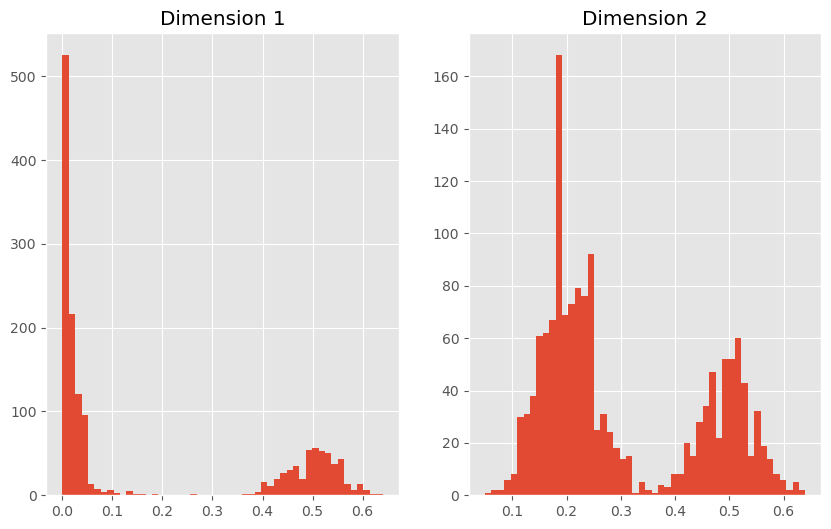

In [20]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [21]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

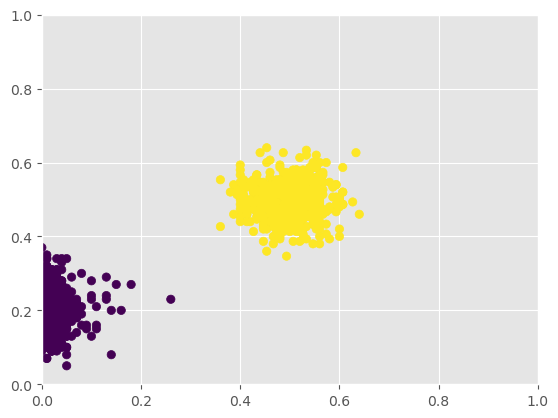

In [22]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


Text(0.5, 1.0, 'kmeans')

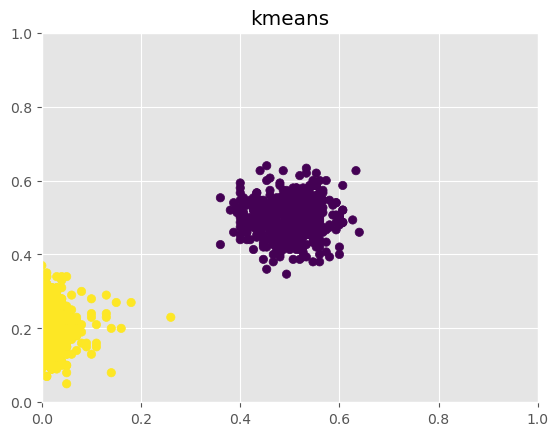

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("kmeans")

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])
Iteration 0: Loss = 5584490.0
weights_param tensor([0.4247, 0.5753], grad_fn=<DivBackward0>)
tail_mean_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
alpha_prec_param tensor([[1.9801, 2.0201],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.0884, 2.1985],
        [1.2423, 1.3575]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5019, 0.4978],
        [0.0192, 0.2022]], grad_fn=<AddBackward0>)
k_beta_param tensor([[50.5025, 50.5025],
        [50.5025, 50.5025]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.5019, 0.4977],
        [0.0189, 0.1998]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.5019, 0.4977],
        [0.0189, 0.1998]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3952, 0.6048],
         [0.3952, 0.6048]],

        [[0.6048, 0.3952],
         [0.3952, 0.6048]]], grad_fn=<DivBackward0>)


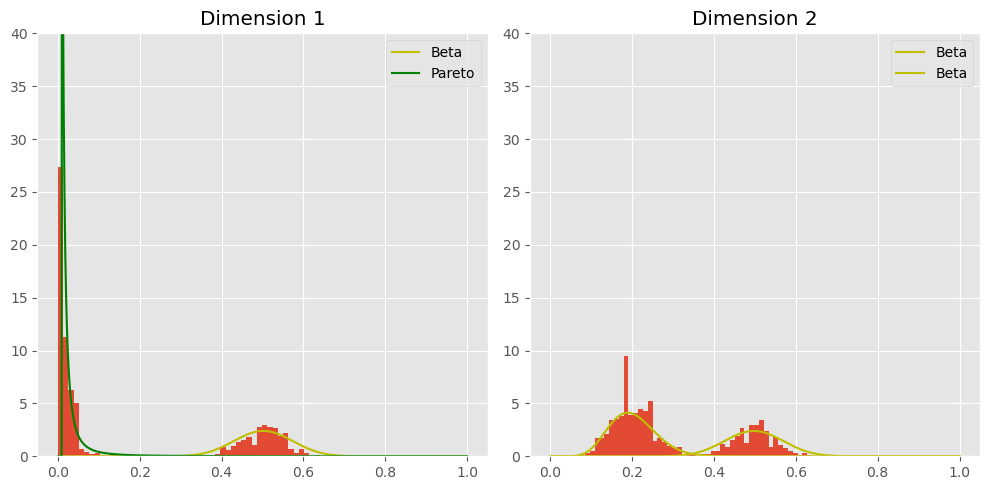

Iteration 200: Loss = -6819443.5
Iteration 400: Loss = -412743904.0
probs_beta [[0.5023406  0.49809098]
 [0.04391559 0.19909005]]


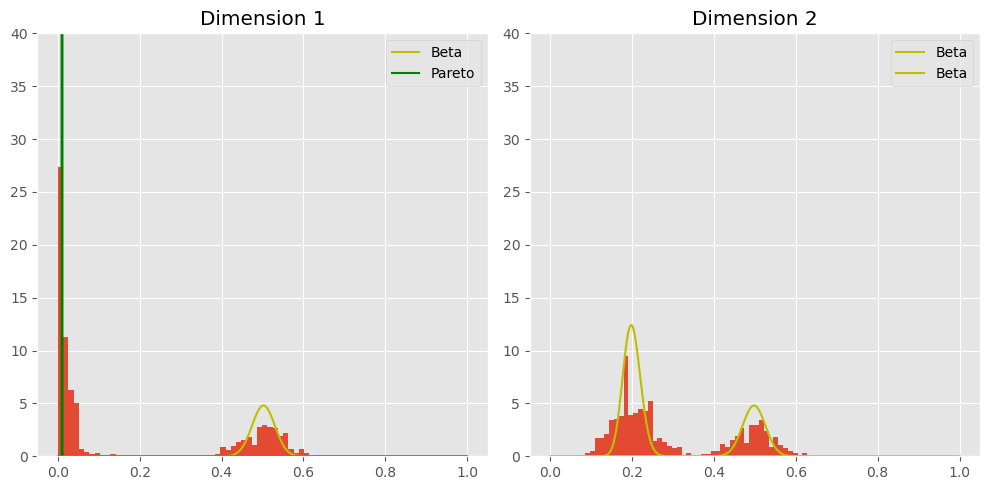

Iteration 600: Loss = -44266074112.0
Iteration 800: Loss = -3640874237952.0
probs_beta [[0.5060688  0.5025094 ]
 [0.04391516 0.44034824]]


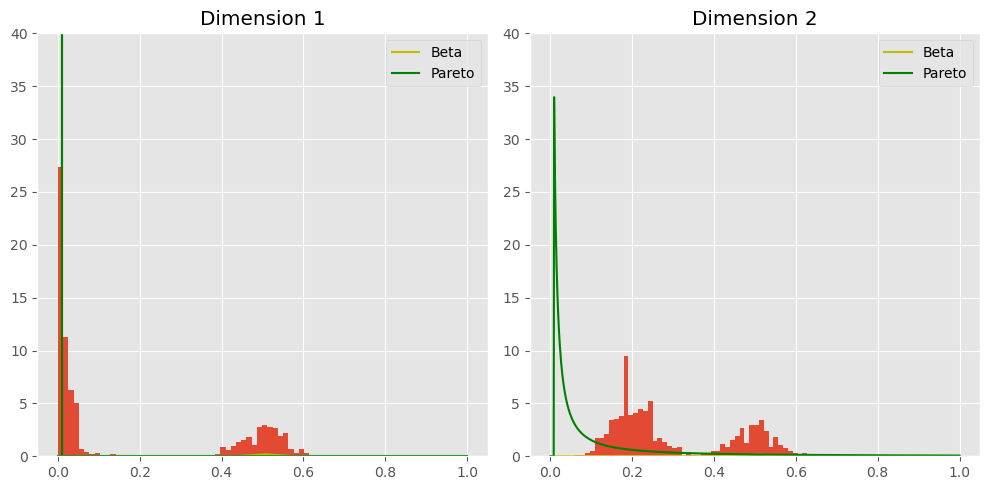

Iteration 1000: Loss = -402492894478336.0
Iteration 1200: Loss = -5.837769370343834e+16
probs_beta [[0.5060688  0.5025094 ]
 [0.04391133 0.46751046]]


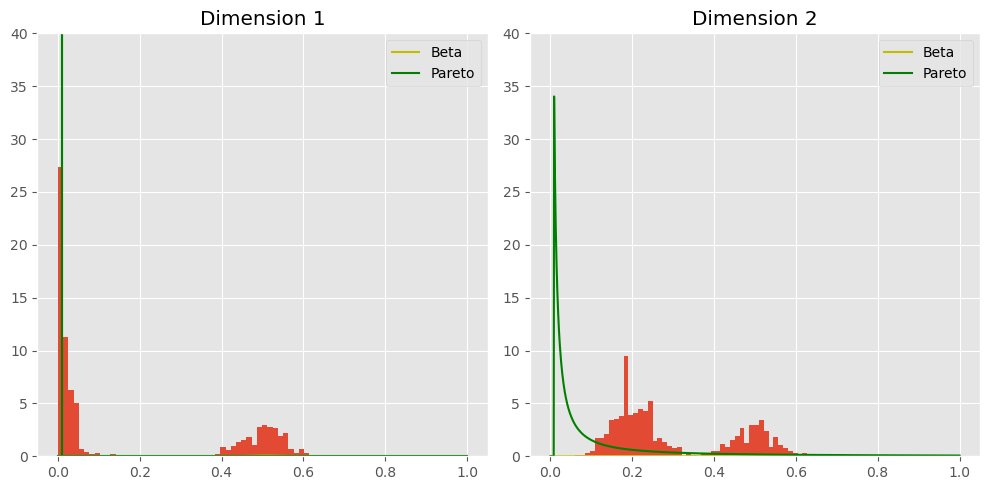

Iteration 1400: Loss = -1.0612987608596218e+19
Iteration 1600: Loss = -1.478481092169926e+20
probs_beta [[0.5060688  0.5025094 ]
 [0.04390751 0.4775408 ]]


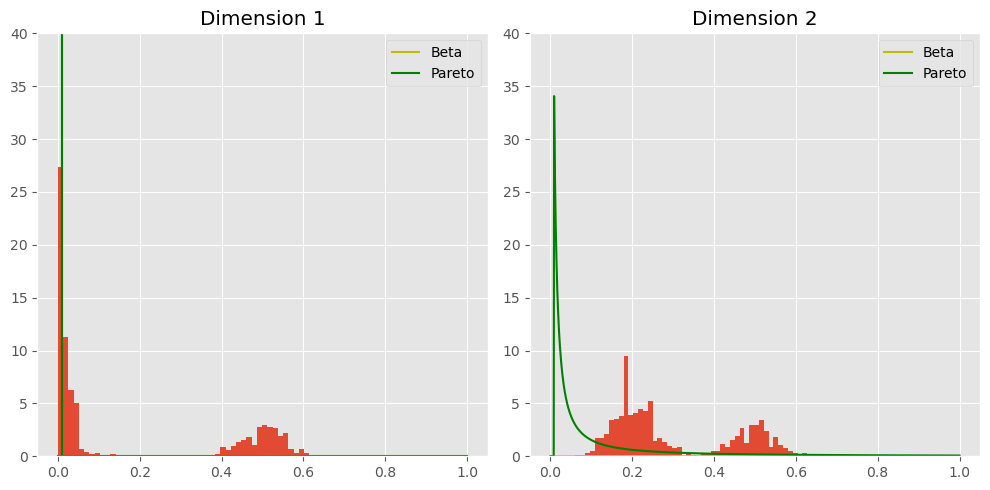

Iteration 1800: Loss = -1.5877880290945794e+20
Iteration 2000: Loss = -1.671117464496746e+20
probs_beta [[0.5060688  0.5025094 ]
 [0.04390368 0.4829223 ]]


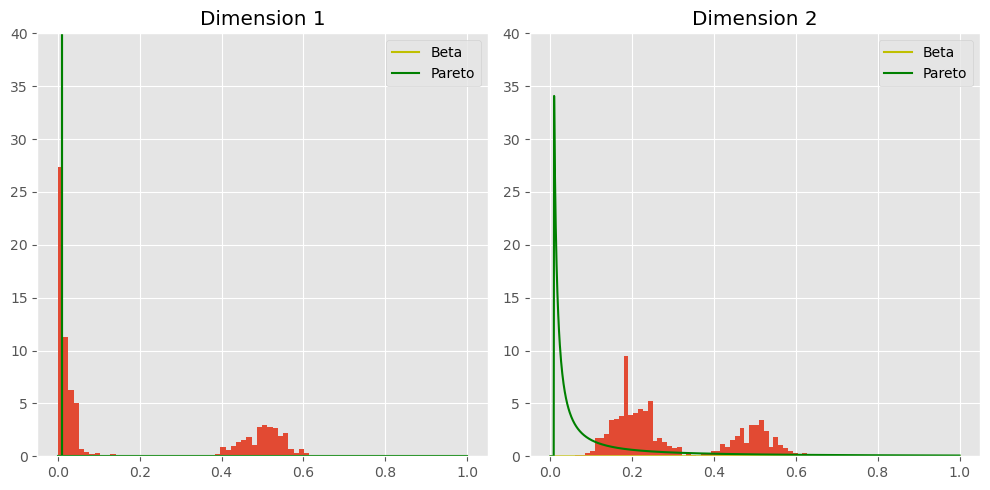

Iteration 2200: Loss = -1.7438806811169155e+20
Iteration 2400: Loss = -1.8107955514084793e+20
probs_beta [[0.5060688  0.5025094 ]
 [0.04389986 0.48627815]]


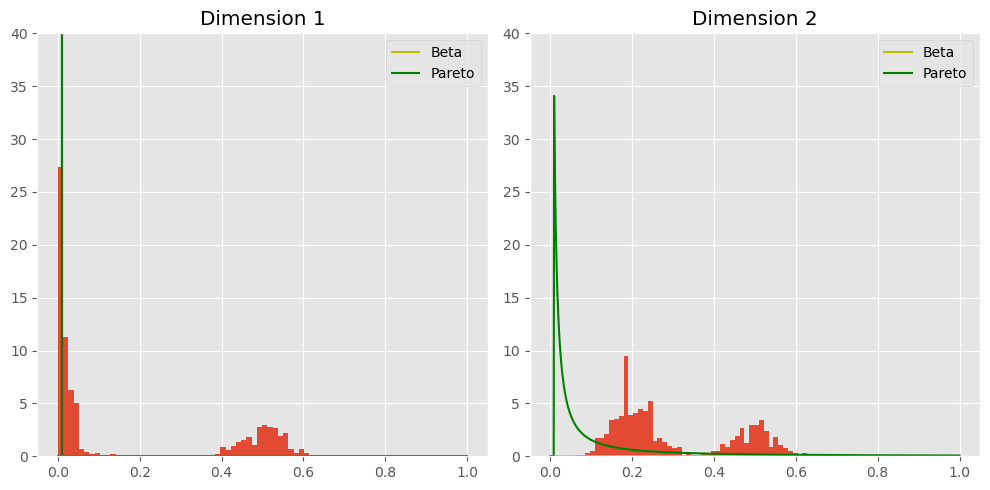

Iteration 2600: Loss = -1.87401377564653e+20
Iteration 2800: Loss = -1.9347092804058114e+20
probs_beta [[0.5060688  0.5025094 ]
 [0.04389222 0.48853266]]


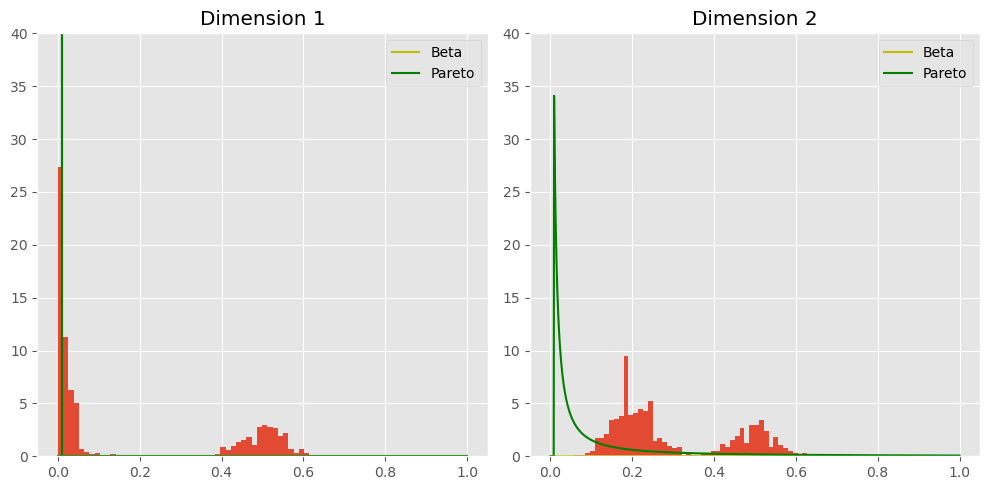

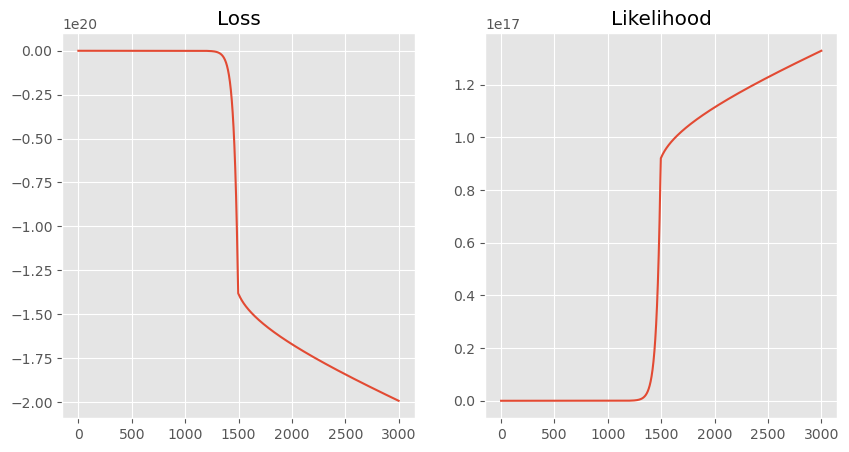

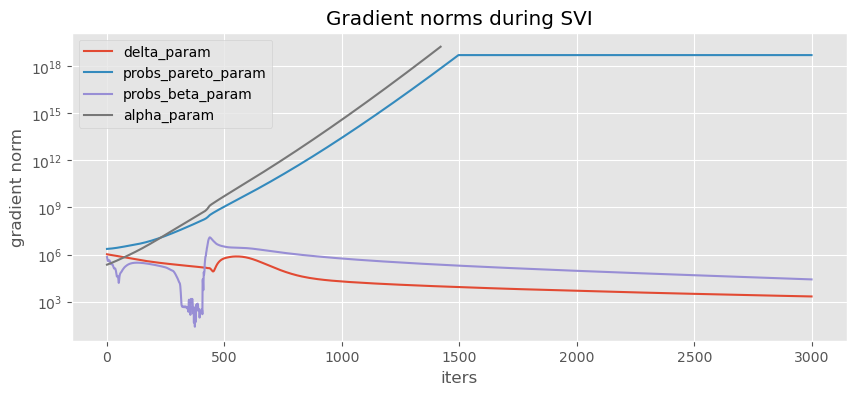

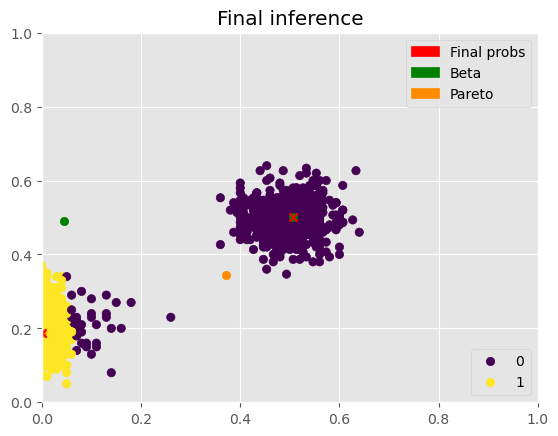

In [24]:
mb = mobster_MV(NV, DP, K = 2, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

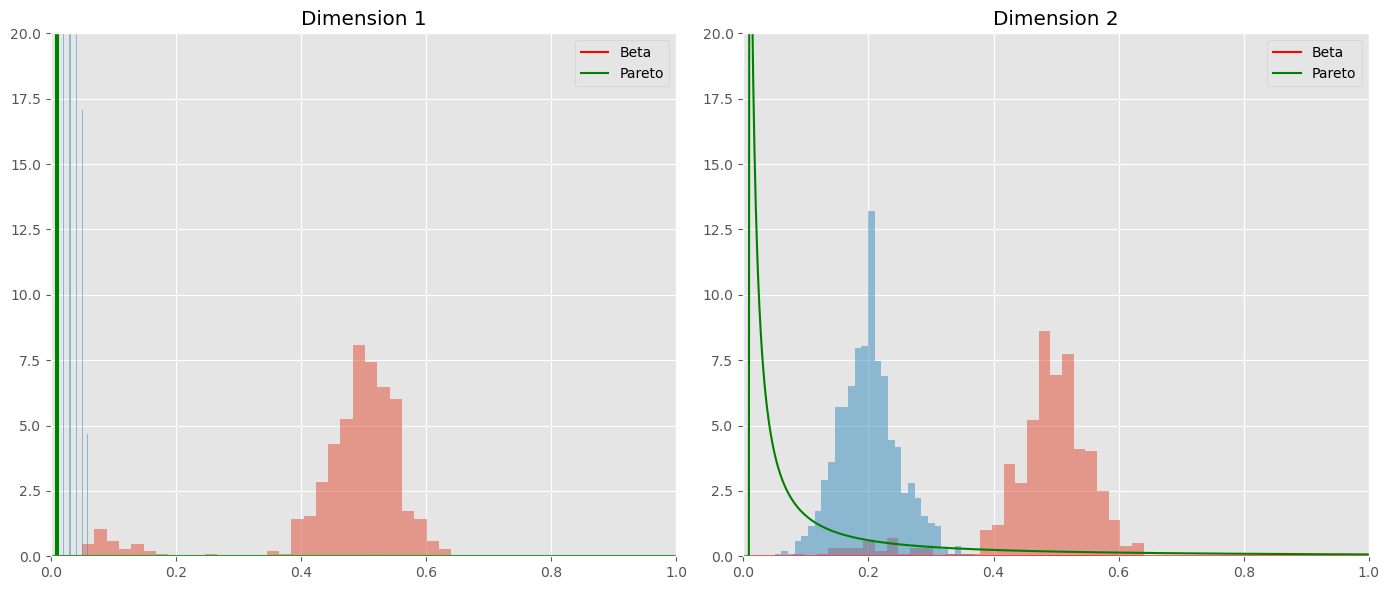

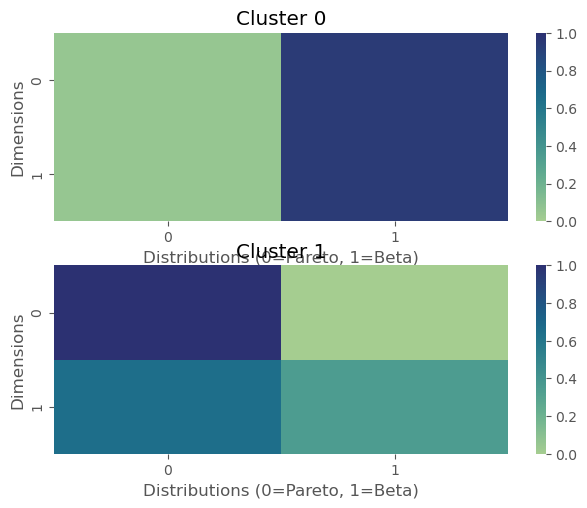

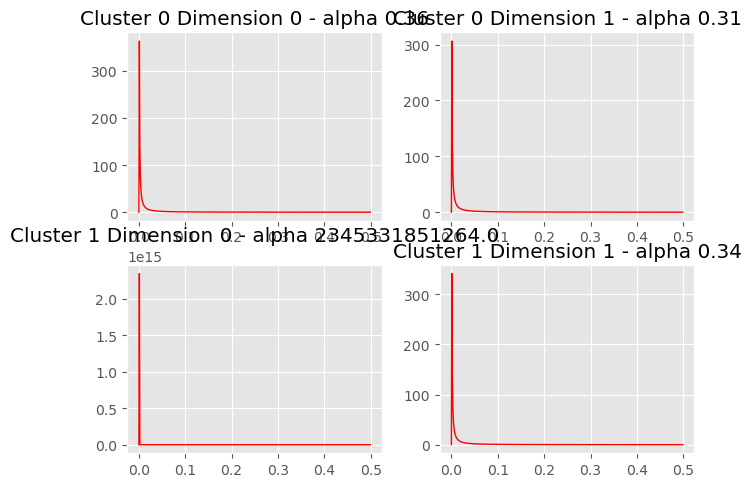

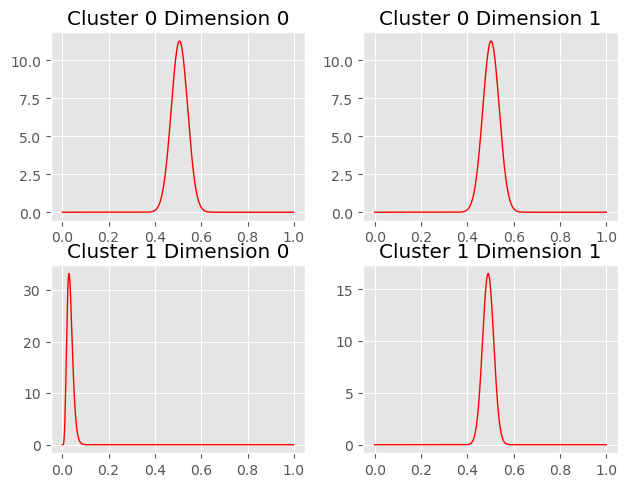

In [25]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [26]:
mb.params

{'probs_beta': tensor([[0.5061, 0.5025],
         [0.0439, 0.4894]]),
 'probs_pareto': tensor([[3.7091e-01, 3.4379e-01],
         [3.9148e-19, 1.8738e-01]]),
 'weights': tensor([9.3962e-04, 9.9906e-01]),
 'delta': tensor([[[5.1307e-02, 9.4869e-01],
          [5.2080e-02, 9.4792e-01]],
 
         [[9.9934e-01, 6.6074e-04],
          [6.5162e-01, 3.4838e-01]]]),
 'alpha_pareto': tensor([[3.6395e-01, 3.0637e-01],
         [2.3453e+12, 3.4123e-01]]),
 'phi_beta': tensor([[0.5058, 0.5017],
         [0.0336, 0.4893]]),
 'k_beta': tensor([[200.0044, 200.0044],
         [199.9994, 428.8173]]),
 'responsib': tensor([[6.0924e-41, 2.2433e-38, 1.9714e-26,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### rRACES data

In [28]:
NV_r = pd.read_csv("../../rRACES_data/NV2.csv")
DP_r = pd.read_csv("../../rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


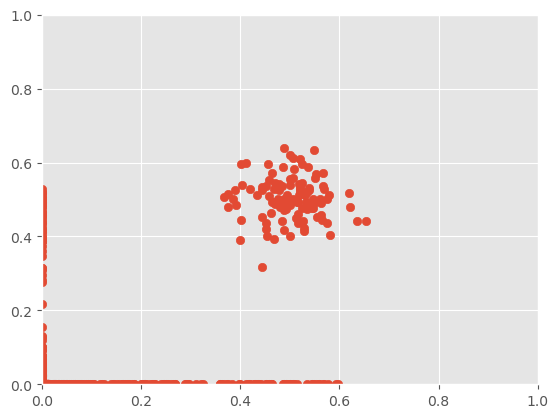

In [29]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

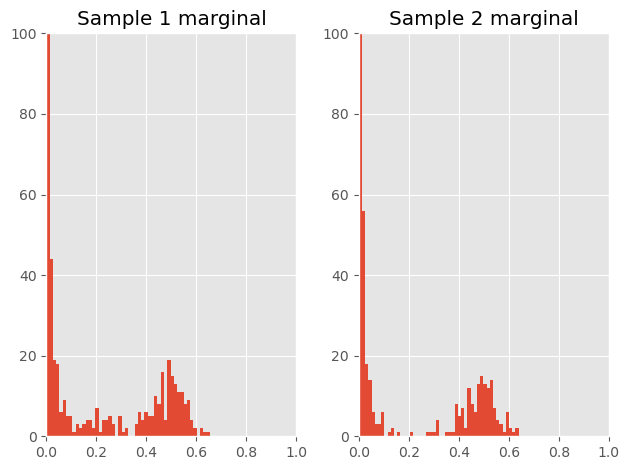

In [30]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])


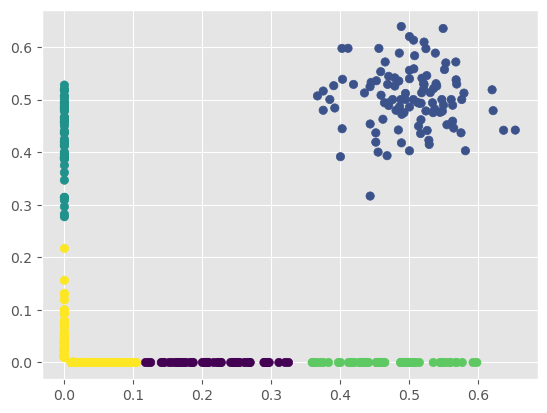

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])
Iteration 0: Loss = -2824684.0
weights_param tensor([0.1778, 0.2361, 0.0279, 0.2615, 0.2968], grad_fn=<DivBackward0>)
tail_mean_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
alpha_prec_param tensor([[1.9801, 2.0201],
        [2.0201, 2.0201],
        [2.0201, 1.9801],
        [2.0201, 1.9801],
        [2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.8755, 2.6582],
        [2.3791, 2.1046],
        [2.7911, 0.9751],
        [3.0180, 1.4738],
        [3.6699, 2.3620]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[2.1827e-01, 1.0100e-03],
        [4.9994e-01, 5.0340e-01],
        [3.0102e-08, 4.2738e-01],
        [4.6994e-01, 1.0100e-03],
        [1.4828e-02, 1.4615e-02]]

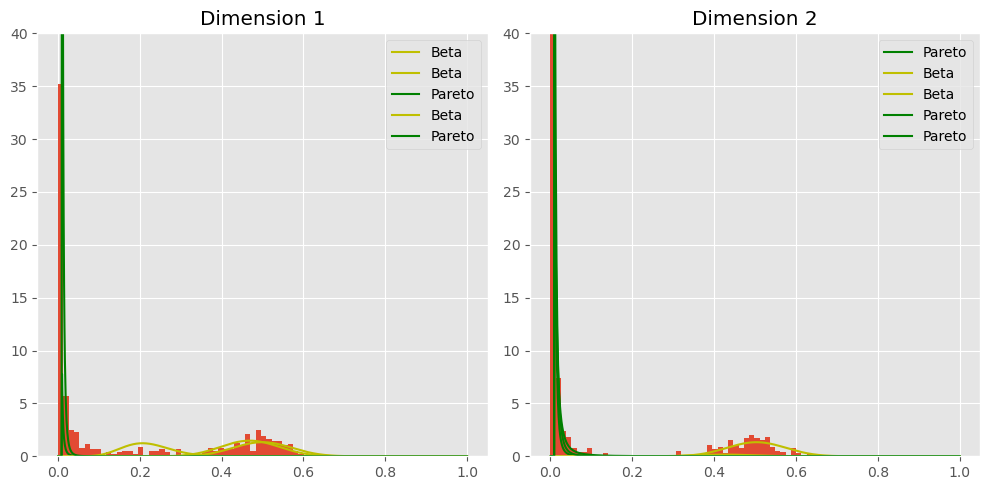

Iteration 200: Loss = -33741036.0
Iteration 400: Loss = -637273088.0
probs_beta [[3.0192858e-01 2.2604861e-04]
 [5.0568992e-01 5.0151318e-01]
 [3.9945229e-09 1.5565637e-01]
 [4.9579391e-01 6.1047741e-04]
 [1.2413506e-02 1.1825079e-02]]


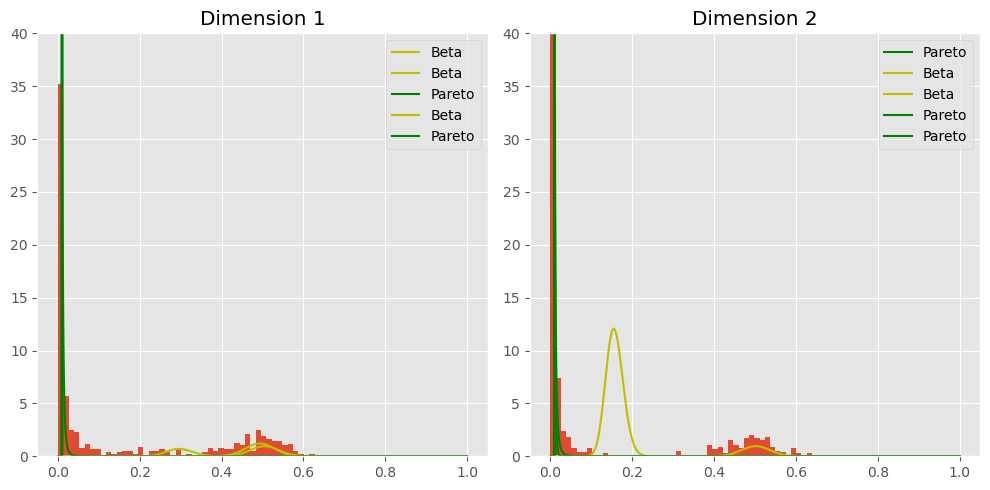

Iteration 600: Loss = -18910257152.0
Iteration 800: Loss = -973301809152.0
probs_beta [[3.0193293e-01 3.9116461e-05]
 [5.0569034e-01 5.0151241e-01]
 [5.4078142e-10 5.0184380e-02]
 [4.9579263e-01 3.9606605e-04]
 [1.2413692e-02 1.1825823e-02]]


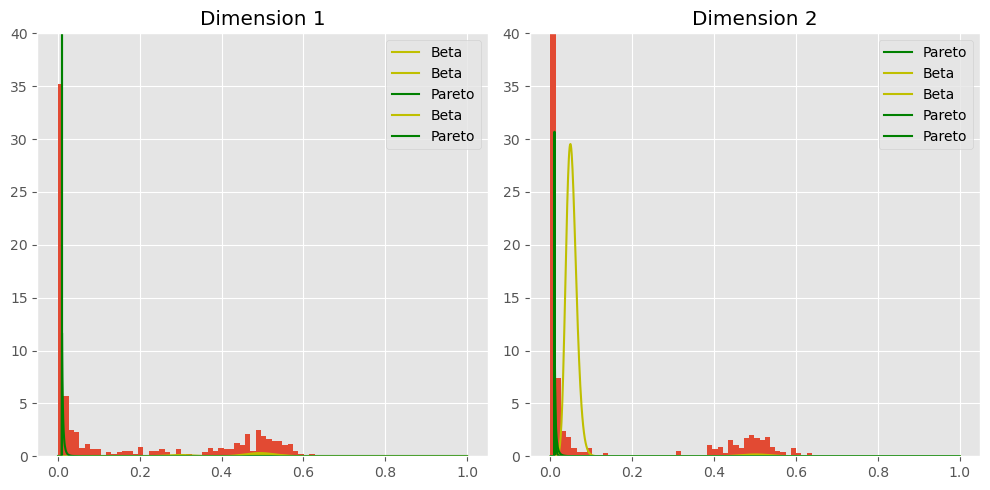

Iteration 1000: Loss = -81534971281408.0
Iteration 1200: Loss = -9851299914842112.0
probs_beta [[3.0193144e-01 5.1280908e-06]
 [5.0569034e-01 5.0151336e-01]
 [7.3291713e-11 2.5423206e-02]
 [4.9579132e-01 2.2664997e-04]
 [1.2414847e-02 1.1826925e-02]]


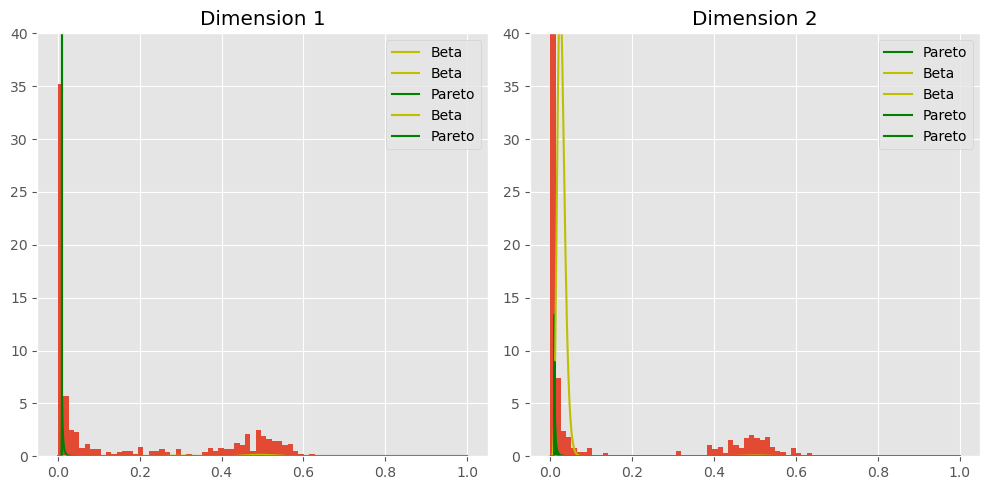

Iteration 1400: Loss = -1.576522652858712e+18


ValueError: Expected parameter probs (Tensor of shape (593, 2)) of distribution Binomial(total_count: torch.Size([593, 2]), probs: torch.Size([593, 2])) to satisfy the constraint Interval(lower_bound=0.0, upper_bound=1.0), but found invalid values:
tensor([[   nan, 0.4689],
        [   nan, 0.4689],
        [   nan, 0.4689],
        ...,
        [   nan, 0.4689],
        [   nan, 0.4689],
        [   nan, 0.4689]])

In [32]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

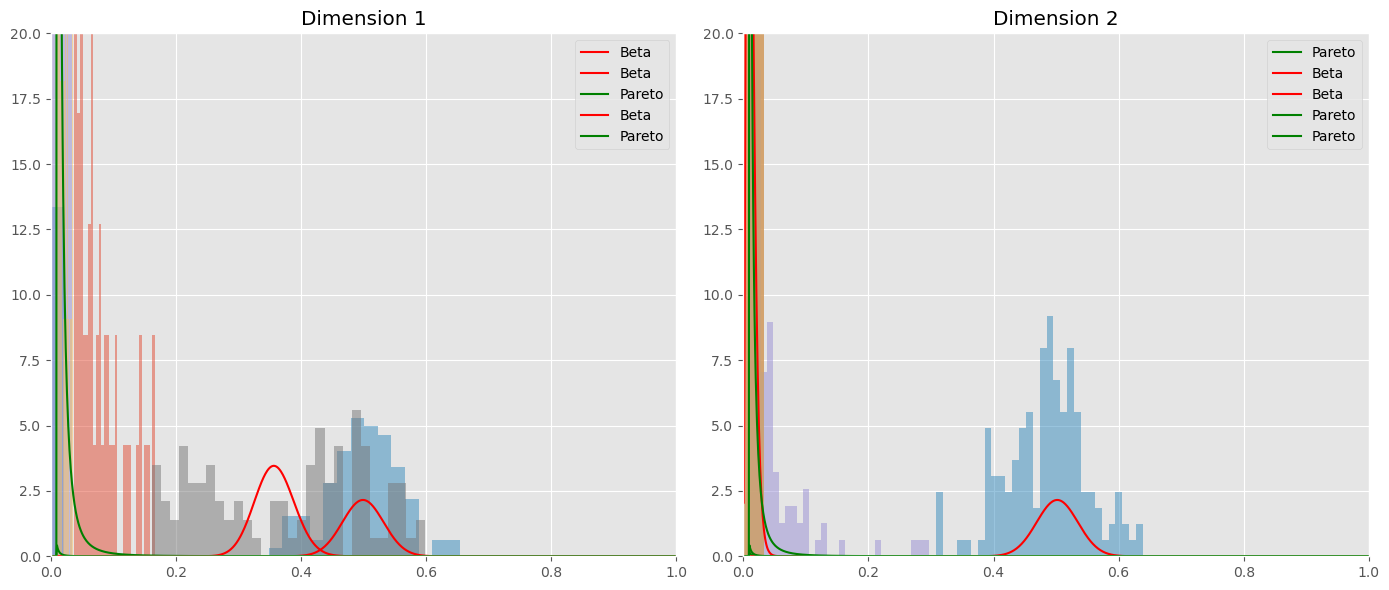

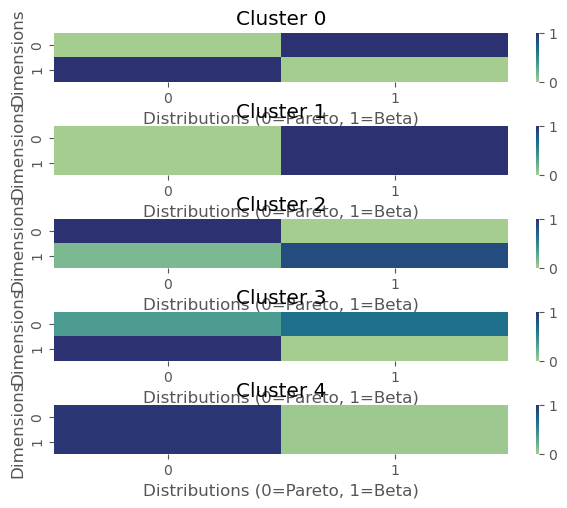

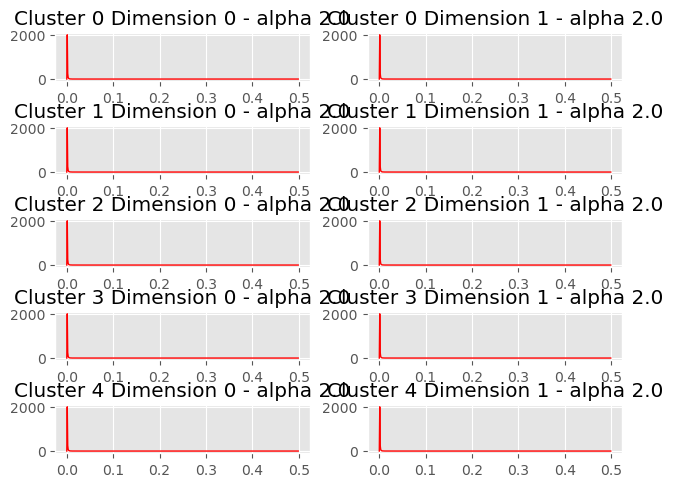

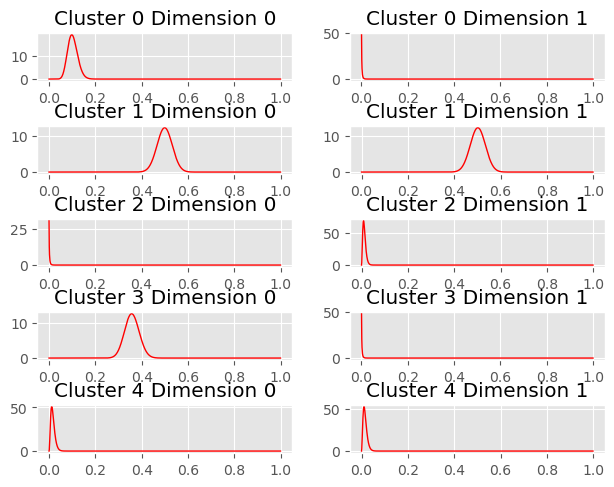

In [ ]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [ ]:
mb.params

{'probs_beta': tensor([[1.0093e-01, 3.2809e-10],
         [4.9903e-01, 5.0188e-01],
         [1.0434e-14, 1.0373e-02],
         [3.5710e-01, 3.1571e-10],
         [1.0741e-02, 9.6232e-03]]),
 'probs_pareto': tensor([[1.0166e-01, 1.1645e-06],
         [1.3574e-07, 1.6643e-07],
         [2.7781e-15, 3.9340e-01],
         [2.6099e-02, 2.4307e-11],
         [6.3997e-03, 5.9236e-03]]),
 'weights': tensor([0.0007, 0.1769, 0.5481, 0.2723, 0.0021]),
 'delta': tensor([[[1.9488e-03, 9.9805e-01],
          [9.9809e-01, 1.9071e-03]],
 
         [[4.5198e-04, 9.9955e-01],
          [4.5200e-04, 9.9955e-01]],
 
         [[9.9980e-01, 1.9714e-04],
          [1.4708e-01, 8.5292e-01]],
 
         [[3.5269e-01, 6.4731e-01],
          [9.9980e-01, 2.0469e-04]],
 
         [[9.7131e-01, 2.8690e-02],
          [9.7140e-01, 2.8603e-02]]]),
 'alpha_pareto': tensor([[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]]),
 'phi_beta': tensor([[1.0216e-01, 3.1432e-04],
         [

### rRACES longitudinal data

In [33]:
NV_r = pd.read_csv("../../rRACES_data/NV_long.csv")
DP_r = pd.read_csv("../../rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


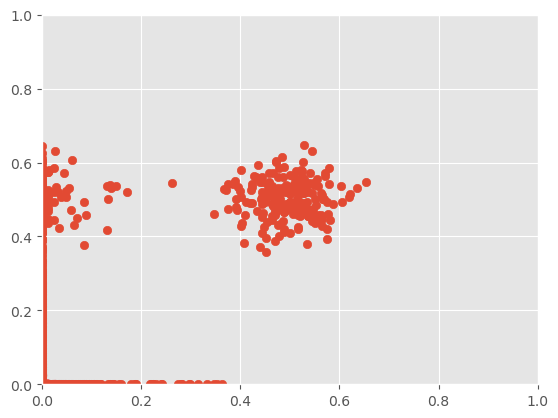

In [34]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

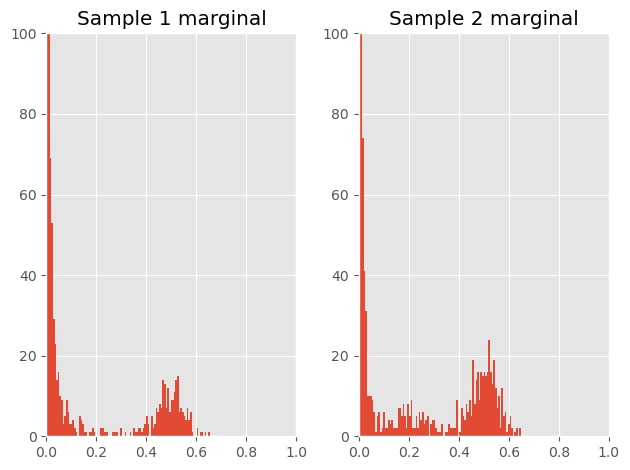

In [35]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.0000e-03],
        [2.2352e-08, 2.1557e-01]])


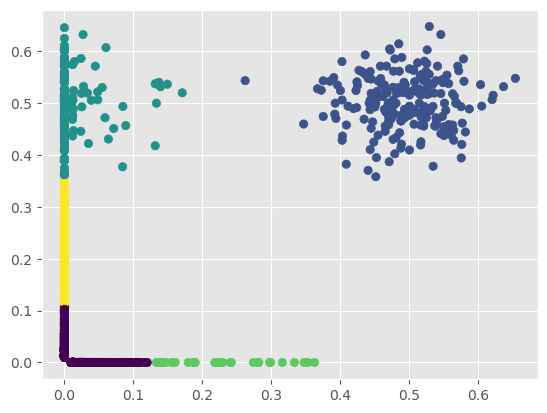

In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

kmeans_centers:  tensor([[2.2878e-02, 1.1322e-02],
        [4.4452e-01, 4.9081e-01],
        [1.6109e-02, 4.9525e-01],
        [5.3156e-01, 5.1208e-01],
        [2.2352e-08, 2.1557e-01]])
Iteration 0: Loss = -18046960.0
weights_param tensor([0.3161, 0.1105, 0.2489, 0.0579, 0.2665], grad_fn=<DivBackward0>)
tail_mean_param tensor([[2.0200, 1.9801],
        [1.9801, 2.0201],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 2.0200]], grad_fn=<AddBackward0>)
alpha_prec_param tensor([[2.0201, 1.9801],
        [1.9802, 2.0201],
        [1.9806, 1.9801],
        [2.0201, 2.0201],
        [1.9801, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[4.1018, 1.1038],
        [1.9254, 4.5229],
        [1.9338, 0.9252],
        [2.7985, 3.0860],
        [1.6584, 3.9809]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[2.3098e-02, 1.1433e-02],
        [4.4509e-01, 4.9099e-01],
        [1.6266e-02, 4.9539e-01],
        [5.1000e-01, 5.1000e-01],
        [2.2576e-08, 2.1681e-01]

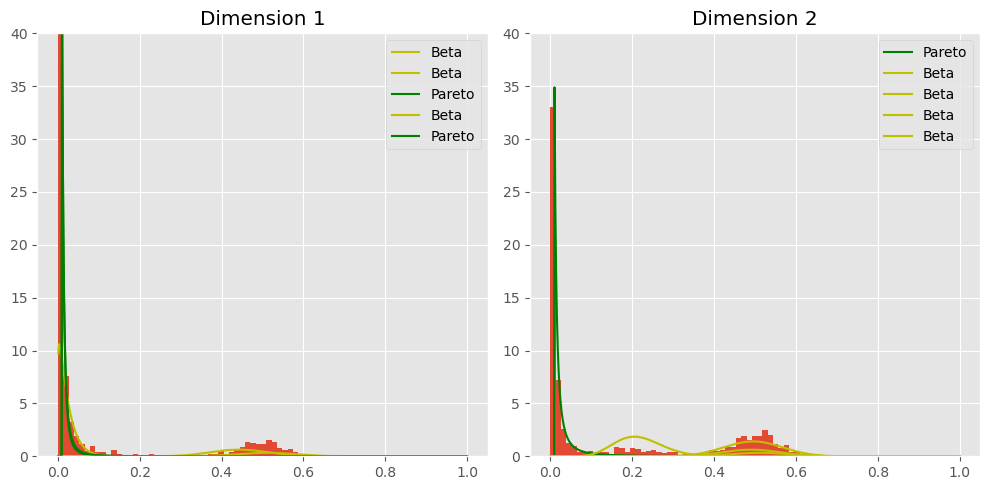

Iteration 200: Loss = -105576576.0
Iteration 400: Loss = -1224979968.0
probs_beta [[7.9928733e-02 8.3183637e-03]
 [4.6397835e-01 4.9166995e-01]
 [6.7339458e-02 5.0197810e-01]
 [5.0999975e-01 5.0999719e-01]
 [2.9958880e-09 2.7435070e-01]]


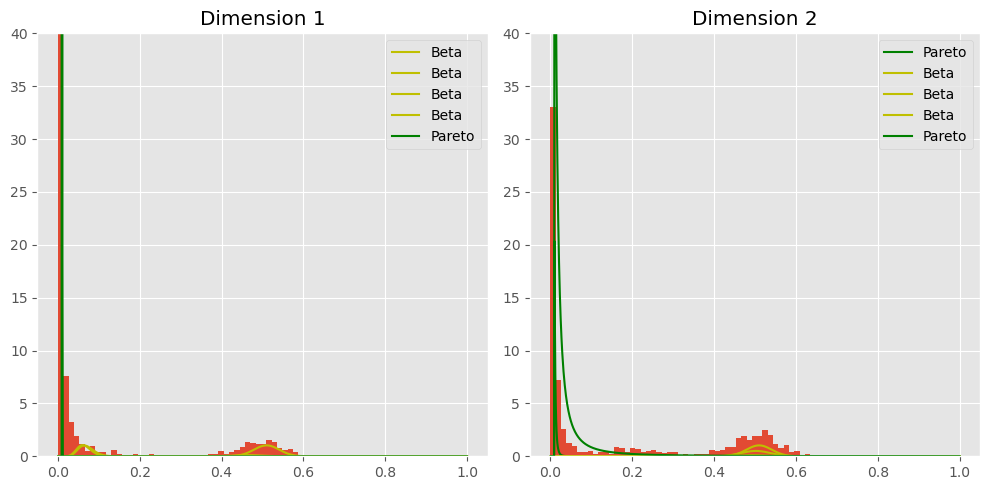

Iteration 600: Loss = -37755416576.0
Iteration 800: Loss = -1946346061824.0
probs_beta [[7.9929732e-02 8.3183637e-03]
 [4.6400991e-01 4.9165973e-01]
 [6.7333221e-02 5.0197810e-01]
 [5.0999975e-01 5.0999719e-01]
 [4.0558548e-10 3.9518899e-01]]


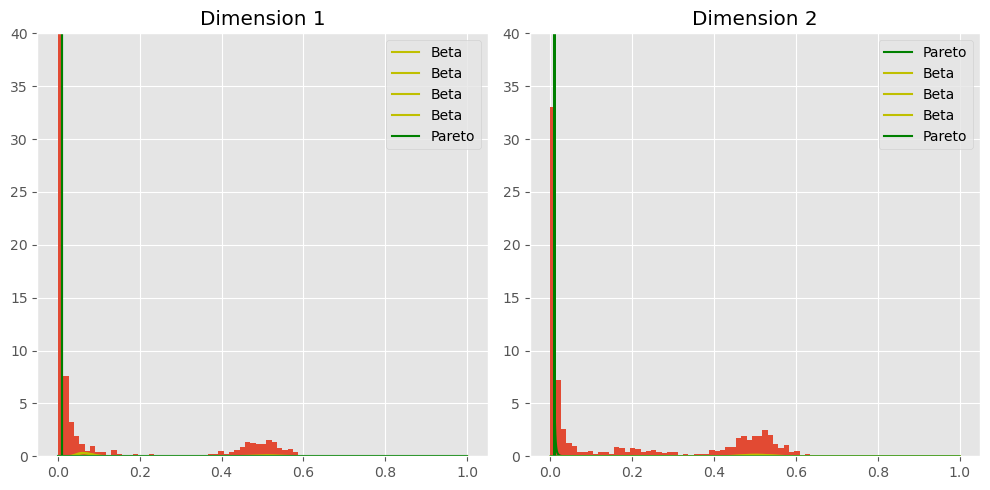

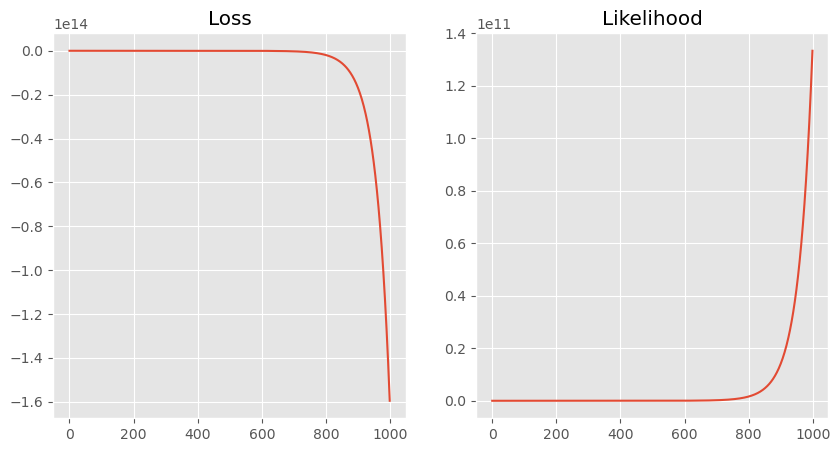

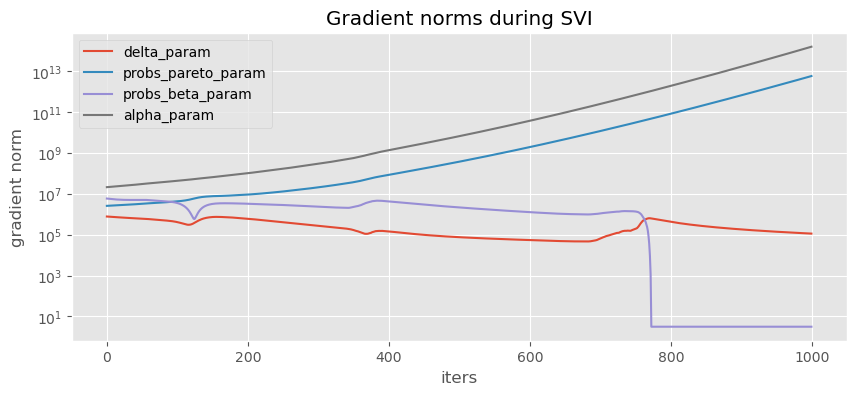

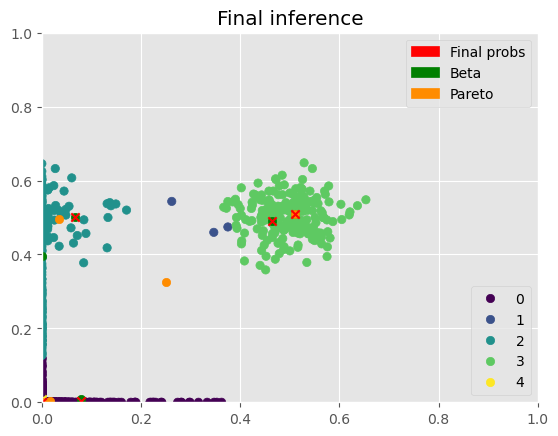

In [37]:
mb = mobster_MV(NV, DP, K = 5, seed = 25)
mb.fit(num_iter = 1000, lr = 0.005)

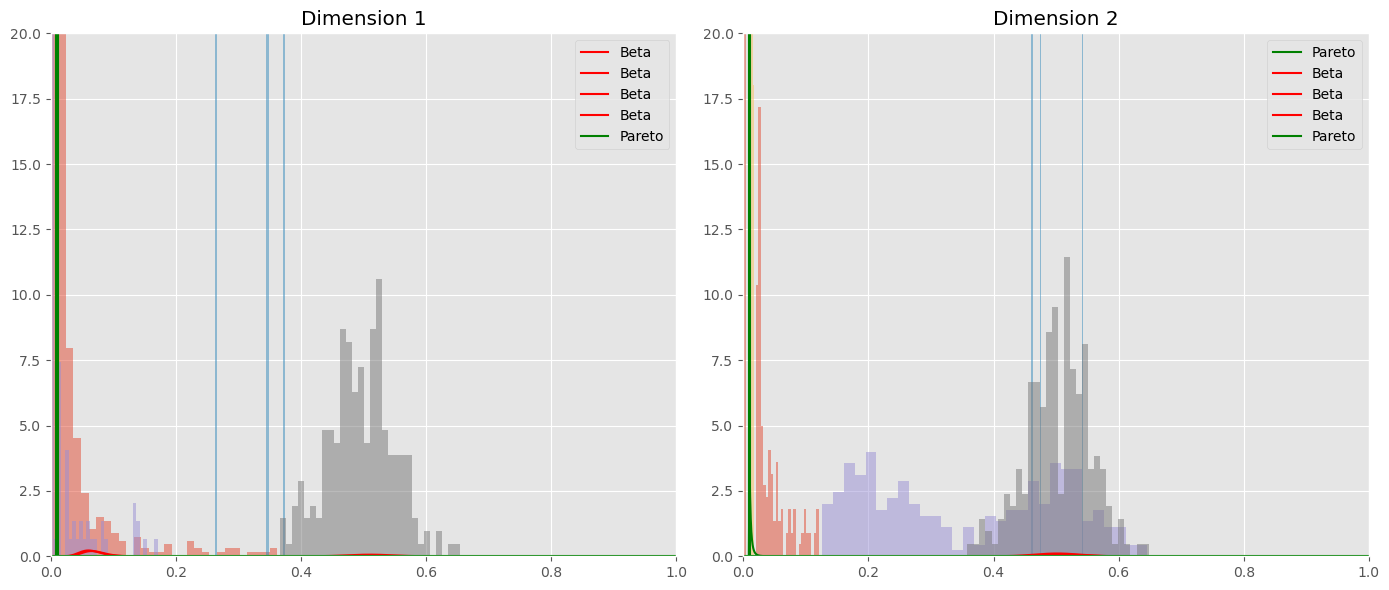

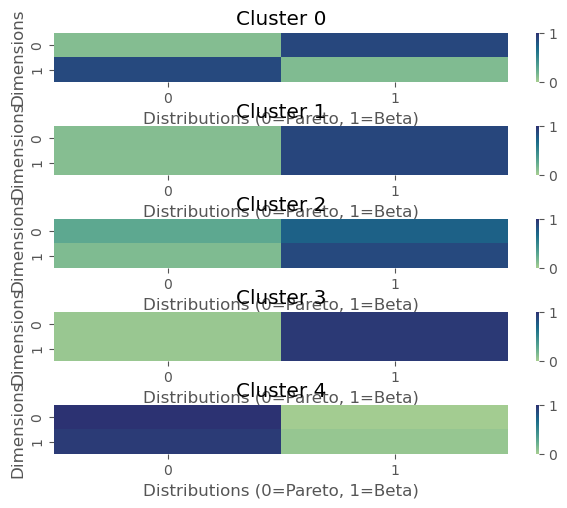

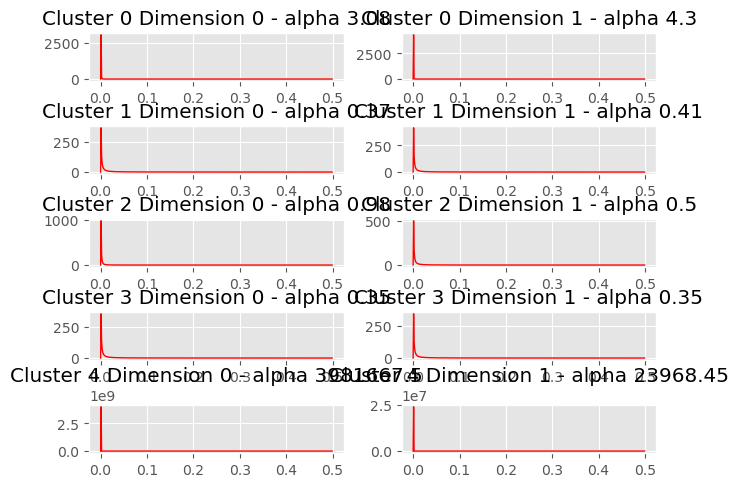

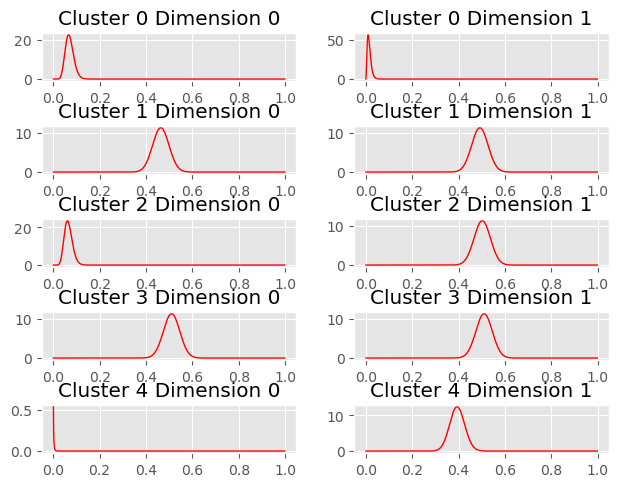

In [38]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [39]:
mb.params

{'probs_beta': tensor([[7.9930e-02, 8.3184e-03],
         [4.6401e-01, 4.9166e-01],
         [6.7329e-02, 5.0198e-01],
         [5.1000e-01, 5.1000e-01],
         [1.4999e-10, 3.9523e-01]]),
 'probs_pareto': tensor([[1.5864e-02, 4.0833e-03],
         [2.4981e-01, 3.2567e-01],
         [3.3861e-02, 4.9626e-01],
         [5.1000e-01, 5.1000e-01],
         [1.3610e-14, 4.7784e-06]]),
 'weights': tensor([8.7674e-03, 8.6766e-04, 9.4386e-03, 5.5127e-03, 9.7541e-01]),
 'delta': tensor([[[0.1201, 0.8799],
          [0.8683, 0.1317]],
 
         [[0.1151, 0.8849],
          [0.1095, 0.8905]],
 
         [[0.2665, 0.7335],
          [0.1347, 0.8653]],
 
         [[0.0442, 0.9558],
          [0.0442, 0.9558]],
 
         [[0.9889, 0.0111],
          [0.9481, 0.0519]]]),
 'alpha_pareto': tensor([[3.0844e+00, 4.2956e+00],
         [3.6817e-01, 4.1486e-01],
         [9.7968e-01, 5.0114e-01],
         [3.5159e-01, 3.4601e-01],
         [3.9817e+06, 2.3968e+04]]),
 'phi_beta': tensor([[6.9716e-02, 1.4